In [14]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from Data_Load_Assign_Visual import *
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [15]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

| using device: cuda


In [4]:
# Load Dataset
train_data, test_data = load_MNIST()

# Get client dataloaders
iid_train_loader = iid_Assign(train_data)
noniid_train_loader = non_iid_Assign(train_data)

test_inputs, test_labels = zip(*test_data)
test_inputs = torch.stack(test_inputs).to(device)
test_labels = torch.Tensor(test_labels).to(device)

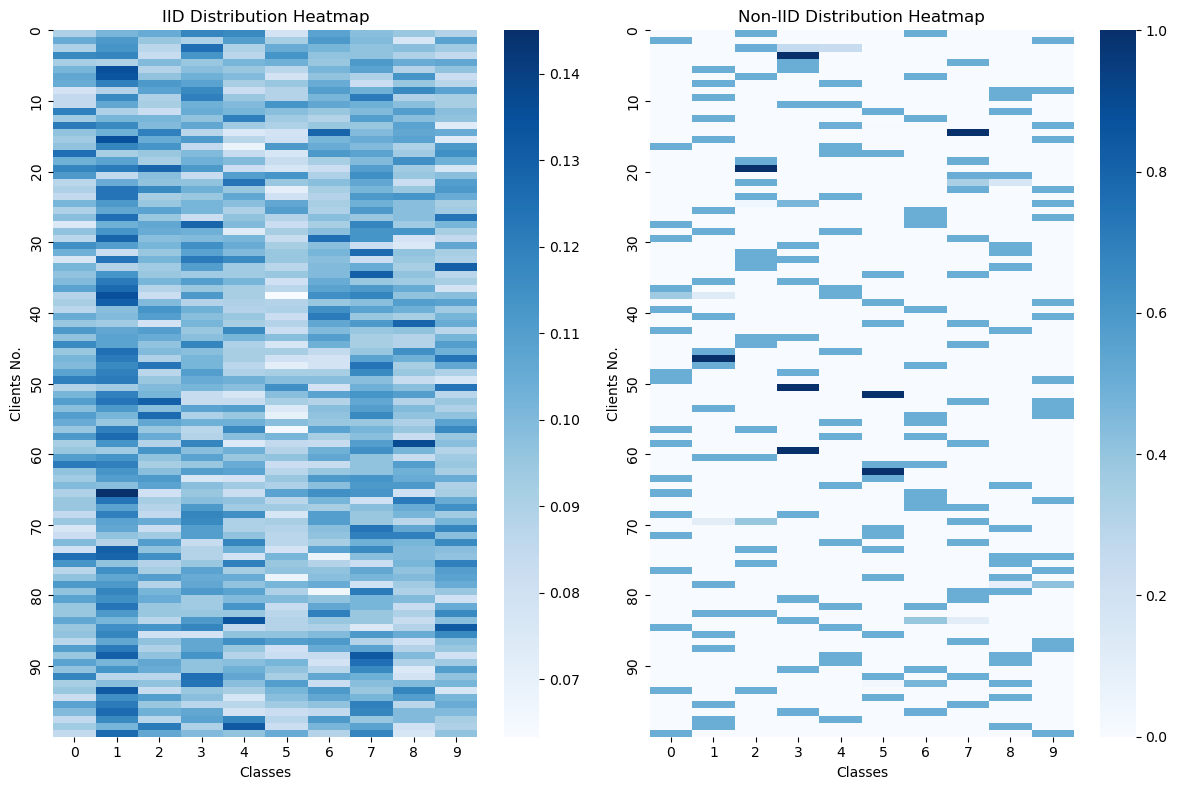

In [5]:
# Test iid and non-iid is correct.

# iid
iid_labels = []
for i in iid_train_loader:
    iid_label = torch.zeros(10)
    for (x,y) in i:
        iid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    iid_labels.append(iid_label)
    
iid_labels = torch.stack(iid_labels)
iid_normalized = iid_labels / 600 # min-max normalization

# non_iid
noniid_labels = []
for i in noniid_train_loader:
    noniid_label = torch.zeros(10)
    for (x,y) in i:
        noniid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    noniid_labels.append(noniid_label)
    
noniid_labels = torch.stack(noniid_labels)
noniid_normalized = noniid_labels / 600

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.heatmap(iid_normalized.numpy(), cmap='Blues', fmt=".2f", cbar=True, annot=False)
plt.yticks(np.arange(0, 100, step=10), [i * 10 for i in range(10)])
plt.xlabel('Classes')
plt.ylabel('Clients No.')
plt.title('IID Distribution Heatmap')

plt.subplot(1, 2, 2)
sns.heatmap(noniid_normalized.numpy(), cmap='Blues', fmt=".2f", cbar=True, annot=False)
plt.yticks(np.arange(0, 100, step=10), [i * 10 for i in range(10)])
plt.xlabel('Classes')
plt.ylabel('Clients No.')
plt.title('Non-IID Distribution Heatmap')

plt.tight_layout()
plt.show()

In [6]:
# Model Defination

# Model 1: A simple multilayer-perceptron with 2-hidden
# layers with 200 units each using ReLu activations (199,210
# total parameters), which we refer to as the MNIST 2NN.

# define fully connected NN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # torch.Size([B,784])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

print(MLP())
print("Total parameters of 2NN(MLP) is", num_params(MLP()))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
Total parameters of 2NN(MLP) is 199210


In [7]:
# Fed_Avg
def fedavg(global_model, C, K, E, c_loader, rounds, lr, acc_threshold):
    # C is the fraction of clients that perform computation on each round.
    assert C <= 1 and C >= 0
    # K is the number of clients.
    # E is the local epochs, the number of training passes each client makes
    # over its local dataset on each round.
    
    c_per_round = max( round(C * K), 1)
    accuracy = []
    entropys_of_rounds = []
    
    for rd in range(rounds):
        
        # Choose c_per_round clients
        clients = random.sample(range(K), c_per_round)
        
        # Train on clients one by one
        client_model = []
        entropys_of_clients = []
        for i, c in enumerate(clients):
            local_model, entropy = client_training(global_model, id = c, local_epochs = E, dataloader = c_loader[c], lr = lr)
            local_model = local_model.to(device)
            client_model.append(local_model.state_dict())
            entropys_of_clients.append(entropy)
        
        entropys_of_rounds.append(entropys_of_clients)
    
        # Average and iterate global model parameters for next round  
        keys = client_model[0].keys()
        next_global_dict = {key: 0 for key in keys}
        for key in keys:
            values = [d[key] for d in client_model]
            averaged_value = sum(values) / len(values)
            next_global_dict[key] = averaged_value
            
        global_model.load_state_dict(next_global_dict)
        global_model = global_model.to(device)
        
        # Validate accuracy this round

        global_model.eval()
        with torch.no_grad():
            predictions = global_model(test_inputs)

        predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        true_labels = test_labels.cpu().numpy()

        acc = accuracy_score(true_labels, predicted_labels)
        if rd%10 == 0 or acc >= acc_threshold:
            print("The clients in round {} are: {}".format(rd, clients))
            print("Accuracy of round {}:{}".format(rd, acc))
            print()
        accuracy.append(acc)
        if acc >= acc_threshold:
            break
        
    return accuracy, entropys_of_rounds

Choose entropy for uncertainty estimation:
$$\mathbb{H}[y|\mathbf{x},\mathcal{D}_{test}]:=-\sum_{c}p(y=c|\mathbf{x},\mathcal{D}_{test})\log p(y=c|\mathbf{x},\mathcal{D}_{test})$$

In [8]:
# Calculate the averaged entropy of the local model after every local training
def calculate_entropy(output):
    # The differences between 2NN and CNN, 2NN doesn't have a softmax layer
    probabilities = F.softmax(output, dim=1)
    log_probabilities = torch.log(probabilities)
    entropy = -torch.sum(probabilities * log_probabilities, dim=1)
    return entropy.mean().item()

In [9]:
criterion = nn.CrossEntropyLoss()

def client_training(global_model, id, local_epochs, dataloader, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
    
    for epoch in range(local_epochs):
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Calculate the Averaged Entropy After All Epoches:
    with torch.no_grad():
        test_outputs = local_model(test_inputs)
        entropy = calculate_entropy(test_outputs)            
            
    return local_model, entropy

# MNIST 2NN

In [19]:
mlp = MLP()
acc_threshold_2nn = 0.97

In [27]:
def pltUncertainty(A, title):
    max_values = [np.max(a_i) for a_i in A]
    min_values = [np.min(a_i) for a_i in A]
    avg_values = [np.mean(a_i) for a_i in A]


    fig, ax = plt.subplots()

    ax.fill_between(np.log10(range(1, len(A) + 1)), min_values, max_values, facecolor='red', alpha=0.2)

    ax.plot(np.log10(range(1, len(A) + 1)), avg_values, color='blue')

    # plt.ylim(-0.1, 1)
    plt.xticks(np.log10(range(1, len(A) + 1, len(A) // 5)), range(1, len(A) + 1, len(A) // 5))
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Uncertainty(Entropy)')
    ax.set_title(title)

    plt.show()

In [28]:
def pltVar(A, title):
    var_values = [statistics.variance(a_i) for a_i in A]

    fig, ax = plt.subplots()
    ax.plot(range(1, len(A) + 1), var_values, color='blue')
    # ax.plot(np.log10(range(1, len(A) + 1)), var_values, color='blue')

    # plt.ylim(-0.1, 1)
    # plt.xticks(np.log10(range(1, len(A) + 1, len(A) // 5)), range(1, len(A) + 1, len(A) // 5))
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Variance of Uncertainty(Entropy)')
    ax.set_title(title)

    plt.show()

## 1. iid,  C = 0.1

In [12]:
# iid C = 0.1
mlp_iid1 = copy.deepcopy(mlp)
acc_mlp_iid1, entropy_2nn_iid1 = fedavg(mlp_iid1, C = 0.1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [21, 80, 72, 48, 81, 11, 8, 10, 25, 95]
Accuracy of round 0:0.5643

The clients in round 10 are: [10, 66, 5, 8, 28, 16, 38, 1, 97, 57]
Accuracy of round 10:0.9084

The clients in round 20 are: [44, 24, 49, 99, 62, 14, 7, 78, 89, 59]
Accuracy of round 20:0.9318

The clients in round 30 are: [0, 37, 47, 88, 3, 77, 29, 18, 23, 58]
Accuracy of round 30:0.9401

The clients in round 40 are: [22, 31, 58, 43, 66, 18, 45, 59, 80, 81]
Accuracy of round 40:0.9523

The clients in round 50 are: [20, 15, 89, 48, 51, 75, 59, 17, 71, 85]
Accuracy of round 50:0.957

The clients in round 60 are: [7, 95, 81, 86, 22, 29, 78, 38, 11, 90]
Accuracy of round 60:0.9605

The clients in round 70 are: [10, 30, 12, 97, 19, 52, 27, 56, 78, 9]
Accuracy of round 70:0.9638

The clients in round 80 are: [19, 22, 65, 9, 17, 97, 26, 99, 63, 72]
Accuracy of round 80:0.9662

The clients in round 90 are: [57, 55, 18, 45, 39, 22, 83, 42, 93, 95]
Accuracy of round 90:0.968

The clients in round 96 

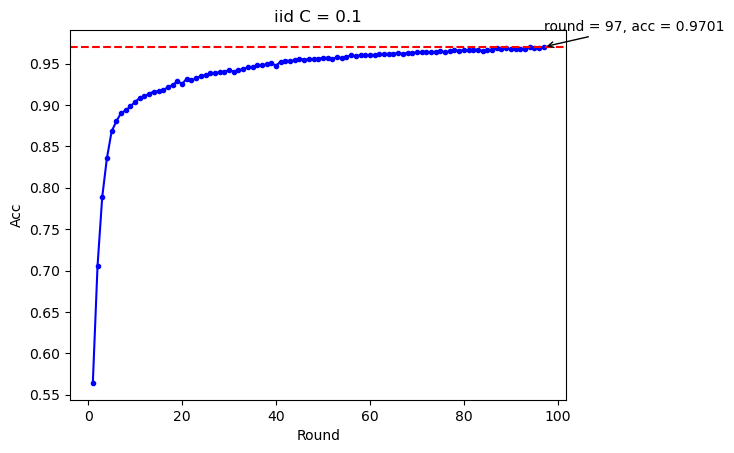

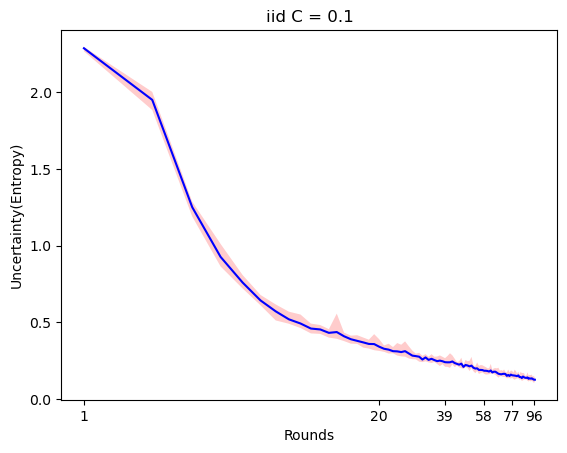

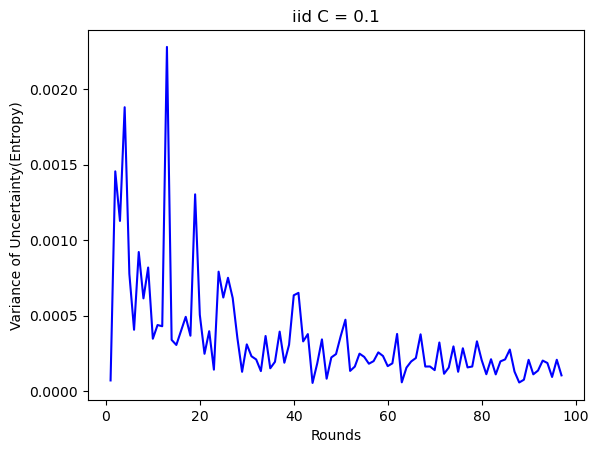

97 rounds needed to achieve the accuracy of 0.9701


In [29]:
pltAcc(acc_mlp_iid1, acc_threshold_2nn, 'iid C = 0.1')
pltUncertainty(entropy_2nn_iid1, 'iid C = 0.1')
pltVar(entropy_2nn_iid1, 'iid C = 0.1')

print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid1), acc_mlp_iid1[-1]))

## 2. iid, C = 0.2

In [ ]:
# iid C = 0.2
mlp_iid2 = copy.deepcopy(mlp)
acc_mlp_iid2, entropy_2nn_iid2  = fedavg(mlp_iid2, C = 0.2, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_iid2, acc_threshold_2nn, 'iid C = 0.2')
pltUncertainty(entropy_2nn_iid2, 'iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid2), acc_mlp_iid2[-1]))

## 3. iid, C = 0.5

In [ ]:
# iid C = 0.5
mlp_iid3 = copy.deepcopy(mlp)
acc_mlp_iid3, entropy_2nn_iid3 = fedavg(mlp_iid3, C = 0.5, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_iid3, acc_threshold_2nn, 'iid C = 0.5')
pltUncertainty(entropy_2nn_iid3, 'iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid3), acc_mlp_iid3[-1]))

## 4. iid, C = 1

In [ ]:
# iid C = 1
mlp_iid4 = copy.deepcopy(mlp)
acc_mlp_iid4, entropy_2nn_iid4 = fedavg(mlp_iid4, C = 1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_iid4, acc_threshold_2nn, 'iid C = 1')
pltUncertainty(entropy_2nn_iid4, 'iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid4), acc_mlp_iid4[-1]))

## 5. non-iid, C = 0.1

In [ ]:
# non-iid C = 0.1
mlp_noniid1 = copy.deepcopy(mlp)
acc_mlp_noniid1, entropy_2nn_noniid1 = fedavg(mlp_noniid1, C = 0.1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid1, acc_threshold_2nn, 'non-iid C = 0.1')
pltUncertainty(entropy_2nn_noniid1, 'non-iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid1), acc_mlp_noniid1[-1]))

## 6. non-iid, C = 0.2

In [ ]:
# non-iid C = 0.2
mlp_noniid2 = copy.deepcopy(mlp)
acc_mlp_noniid2, entropy_2nn_noniid2 = fedavg(mlp_noniid2, C = 0.2, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid2, acc_threshold_2nn, 'non-iid C = 0.2')
pltUncertainty(entropy_2nn_noniid2, 'non-iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid2), acc_mlp_noniid2[-1]))

## 7. non-iid, C = 0.5

In [ ]:
# non-iid C = 0.5
mlp_noniid3 = copy.deepcopy(mlp)
acc_mlp_noniid3, entropy_2nn_noniid3 = fedavg(mlp_noniid3, C = 0.5, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid3, acc_threshold_2nn, 'non-iid C = 0.5')
pltUncertainty(entropy_2nn_noniid3, 'non-iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid3), acc_mlp_noniid3[-1]))

## 8. non-iid, C = 1

In [ ]:
# non-iid C = 1
mlp_noniid4 = copy.deepcopy(mlp)
acc_mlp_noniid4, entropy_2nn_noniid4 = fedavg(mlp_noniid4, C = 1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid4, acc_threshold_2nn, 'non-iid C = 1')
pltUncertainty(entropy_2nn_noniid4, 'non-iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid4), acc_mlp_noniid4[-1]))

## Comparison among 8 groups

In [ ]:
plt.figure(figsize=(12, 8))
log_rounds = np.log10(range(50, 500, 100))
rounds = range(50, 500, 100) 

plt.plot(np.log10(range(1, len(acc_mlp_iid1) + 1)), acc_mlp_iid1, marker='.', linestyle='solid', color='blue', label='iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_iid2) + 1)), acc_mlp_iid2, marker='.', linestyle='solid', color='green', label='iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_iid3) + 1)), acc_mlp_iid3, marker='.', linestyle='solid', color='red', label='iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_iid4) + 1)), acc_mlp_iid4, marker='.', linestyle='solid', color='purple', label='iid, C = 1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid1) + 1)), acc_mlp_noniid1, marker='.', linestyle='dotted', color='orange', label='non-iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid2) + 1)), acc_mlp_noniid2, marker='.', linestyle='dotted', color='cyan', label='non-iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_noniid3) + 1)), acc_mlp_noniid3, marker='.', linestyle='dotted', color='magenta', label='non-iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_noniid4) + 1)), acc_mlp_noniid4, marker='.', linestyle='dotted', color='brown', label='non-iid, C = 1')

plt.axhline(y=acc_threshold_2nn, color='gray', linestyle='solid')

plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.title('Test set accuracy vs. communication rounds for MNIST 2NN')

plt.ylim(0.8, 1)
plt.xticks(log_rounds, rounds)

plt.legend()

plt.show()